In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras



In [72]:
dataset_path = 'numpy_dataset'

keypoint_names = [
    'nose',  # 0
    'left_eye',  # 1
    'right_eye', # 2
    'left_ear', # 3
    'right_ear', # 4
    'left_shoulder', # 5 
    'right_shoulder', # 6
    'left_elbow', # 7
    'right_elbow', # 8
    'left_wrist', # 9
    'right_wrist', # 10
    'left_hip', # 11
    'right_hip', # 12
    'left_knee', # 13
    'right_knee', # 14
    'left_ankle', # 15
    'right_ankle' # 16
    ]

keypoints_to_detect = [
    5, # left shoulder
    7, # left elbow
    9, # left wrist
    13, # left knee
    15, # left ankle
]

In [3]:
dataset = []

for f in os.listdir(dataset_path) :
    with open(os.path.join(dataset_path, f), 'rb') as file:
        data = pickle.load(file)
        print(f, data.shape)

        for i in range(data.shape[1]-30):
            dataset.append(data[:, i:i+30])
        
dataset = np.array(dataset)

01_1R_SG.MOV.pkl (5, 150, 2)
01_1_SG.MOV.pkl (5, 150, 2)
07_1-2_SG.MOV.pkl (5, 150, 2)
08_1_SG.MOV.pkl (5, 150, 2)
10_1-2_SG.MOV.pkl (5, 150, 2)
11_1-2_SG.MOV.pkl (5, 150, 2)
12_1_SG.MOV.pkl (5, 150, 2)
13_1_SG.MOV.pkl (5, 150, 2)
14_1_SG.MOV.pkl (5, 150, 2)
15_1_SG.MOV.pkl (5, 150, 2)
16_1_SG.MOV.pkl (5, 150, 2)
17_1_SG.MOV.pkl (5, 150, 2)
18_1_SG.MOV.pkl (5, 150, 2)
19_1_SG.MOV.pkl (5, 150, 2)
20_1_SG.MOV.pkl (5, 150, 2)


In [4]:
dataset.shape

(1800, 5, 30, 2)

In [17]:
def generate_random_mask() :
    # generate random mask of shape (5, 30, 2) of ones
    # in this random (5, 3, 2) contineous block will be 0's
    mask = np.ones((5, 30, 2))
    start = np.random.randint(0, 30-3)
    mask[:, start:start+3] = 0
    return mask

def prepare_dataset(dataset):
    X = []
    Y = []
    for data in dataset:
        for i in range(10):
            tmp_data = data.copy()
            mask = generate_random_mask()
            tmp_data = tmp_data * mask
            x = np.concatenate([tmp_data, mask], axis=1)
            y = data
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

In [18]:
X, Y = prepare_dataset(dataset)
train_split = 0.7
val_split = 0.15
test_split = 0.15
X_train = X[:int(X.shape[0]*train_split)]
Y_train = Y[:int(Y.shape[0]*train_split)]
X_val = X[int(X.shape[0]*train_split):int(X.shape[0]*(train_split+val_split))]
Y_val = Y[int(Y.shape[0]*train_split):int(Y.shape[0]*(train_split+val_split))]
X_test = X[int(X.shape[0]*(train_split+val_split)):]
Y_test = Y[int(Y.shape[0]*(train_split+val_split)):]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(12600, 5, 60, 2) (12600, 5, 30, 2)
(2700, 5, 60, 2) (2700, 5, 30, 2)
(2700, 5, 60, 2) (2700, 5, 30, 2)


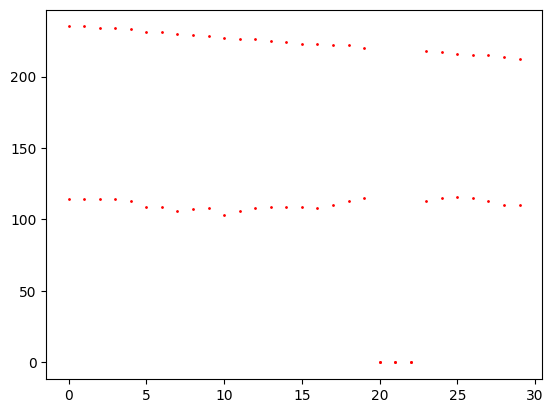

In [26]:
# plot dotted graph
plt.plot(X_train[0, 1, :30], 'ro', markersize=1)

In [27]:
def make_model() :
    # input shape (5, 60, 2)
    # output shape (5, 30, 2)
    inp = keras.layers.Input(shape=(5, 60, 2))
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Conv2DTranspose(2, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(5*30*2)(x)
    x = keras.layers.Reshape((5, 30, 2))(x)
    out = x
    model = keras.Model(inp, out)
    return model
    

In [28]:
model = make_model()

In [29]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 60, 2)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 60, 32)         608       
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 60, 64)         18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 60, 128)        73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 60, 256)        295168    
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 5, 60, 128)       295040    
 ranspose)                                                       
                                                           

In [30]:
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse')

In [31]:
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=100, 
                    batch_size=32,
                    callbacks=[keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)])

Epoch 1/100
394/394 [==============================] - 81s 205ms/step - loss: 2826.0146 - val_loss: 124.3937
Epoch 2/100
394/394 [==============================] - 82s 207ms/step - loss: 261.4795 - val_loss: 39.5111
Epoch 3/100
394/394 [==============================] - 81s 206ms/step - loss: 164.4400 - val_loss: 34.0800
Epoch 4/100
394/394 [==============================] - 81s 205ms/step - loss: 136.8563 - val_loss: 33.6612
Epoch 5/100
394/394 [==============================] - 81s 205ms/step - loss: 118.6145 - val_loss: 27.4096
Epoch 6/100
394/394 [==============================] - 82s 207ms/step - loss: 104.6379 - val_loss: 24.0383
Epoch 7/100
394/394 [==============================] - 80s 203ms/step - loss: 92.8723 - val_loss: 23.1256
Epoch 8/100
394/394 [==============================] - 80s 204ms/step - loss: 83.9617 - val_loss: 21.6859
Epoch 9/100
394/394 [==============================] - 81s 205ms/step - loss: 77.7154 - val_loss: 22.2302
Epoch 10/100
394/394 [================

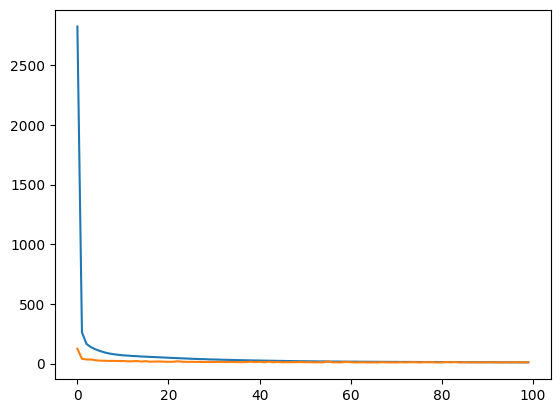

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']  
plt.plot(loss)
plt.plot(val_loss)
plt.show()

1/1 [==============================] - 0s 22ms/step


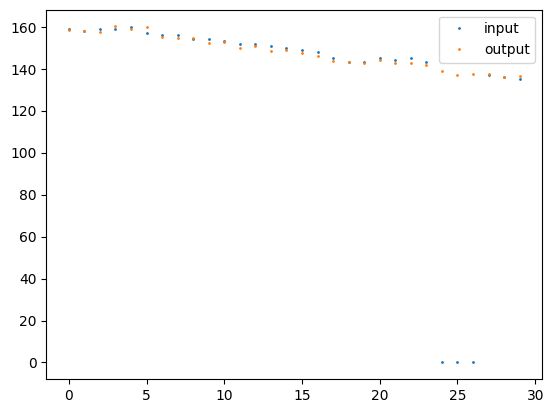

In [62]:
index = np.random.randint(0, X_test.shape[0])
keypoint_index = np.random.randint(0, 5)
y = model.predict(X_test[index:index+1])
# plt.plot(X_test[0, 1, :30], 'ro', markersize=1)
# plt.plot(y[0, 1], 'ro', markersize=1)
# plt.plot(Y_test[index, 1], 'bo', markersize=1)
plt.plot(X_test[index, keypoint_index, :30, 0], 'o', markersize=1)
plt.plot(y[0, keypoint_index, :, 0], 'o', markersize=1)
plt.legend(['input', 'output'])

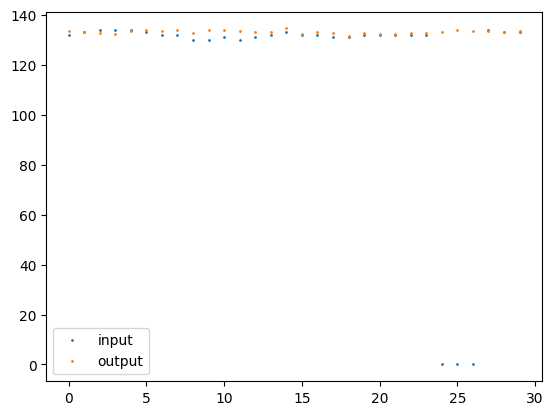

In [67]:
plt.plot(X_test[index, keypoint_index, :30, 1], 'o', markersize=1)
plt.plot(y[0, keypoint_index, :, 1], 'o', markersize=1)
plt.legend(['input', 'output'])

In [68]:
keypoint_index

3

In [65]:
# mse loss on test data
mse_loss = model.evaluate(X_test, Y_test)

# mape loss on test data
mape_score = np.mean(np.abs(Y_test - model.predict(X_test)) / Y_test)

85/85 [==============================] - 5s 57ms/step


In [66]:
print("MSE Loss on Test Data : ", mse_loss)
print("MAPE Score on Test Data : ", mape_score)

MSE Loss on Test Data :  6.408304214477539
MAPE Score on Test Data :  0.011852960192857854
